In [10]:
from scipy.constants import N_A
from scipy.constants import physical_constants
import numpy as np 
from TRIOMA.tools.Extractors.PAV import Component,Membrane ,Geometry ,Fluid
import TRIOMA.tools.materials as materials
import matplotlib.pyplot as plt
from scipy.constants import R

First we define the boundaries for the breeding blanket. Q is the power of the reactor (625 MW in this case), TBR the tritium breeding ratio, Tritium_gen the moles of T generated each second. The recirculation_vec estimates the recirculation ratio in the PAV. Other vectors are defined to store results

In [11]:
Q=0.625E9
TBR=1.08
eV_to_J = physical_constants["electron volt-joule relationship"][0]
reaction_energy = 17.6e6  # reaction energy in eV 17.6 MeV
neutrons = Q / (reaction_energy * eV_to_J)

tritium_gen = TBR * neutrons / N_A 
recirculation_vec=np.linspace(0,10,11)
c_out_PAV_vec=np.array([])
eff_vec=np.array([])
extract_vec=np.array([])
n_pipes_vec=np.array([])

We define properties for the component, the fluid and the membrane. Then we start a while cycle for the component. The PAV gets an inlet concentration which is a weighed average between the outlet of the blanket and the outlet of the PAV times the recirculation ratio. Therefore, the while cycle is looped until the inlet concentration derived by the formula (depending on the outlet concentration in the PAV) matches the inlet concentration at the beginning of the cycle. This is repeated for different recirculation ratios and results are stored and plotted. 

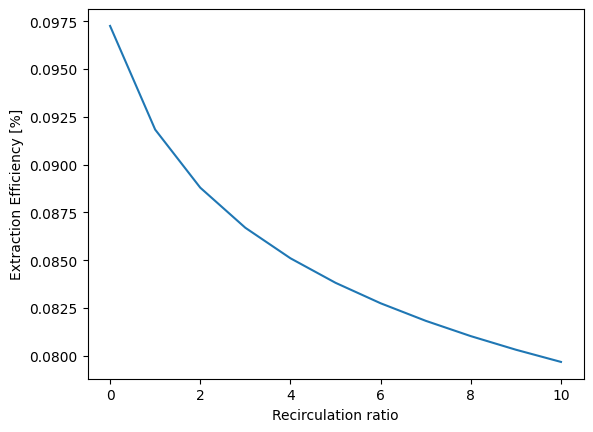

In [12]:
T=973.15
L=10
d_hyd=25.4E-3
U0=2.5
c0=1E-3
mat=materials.Flibe(T)
rho_flibe=2415.6-0.49072*T
mu_flibe=1.16E-4*np.exp(3755/T)
k_H=8.27E-9*np.exp(4.27E-3*T)
D_flibe=9.3E-7*np.exp((-42E3)/(R*T))
K_S_S=953*np.exp((-10.7E3)/(R*T))*1E-3
D_S=7.43E-7*np.exp((-44.1E3)/(R*T))
for recirculation in recirculation_vec:
    
    err=1
    tol=1E-6
    c_in=c0
    i=0
    flibe=Fluid(T=T, Solubility=k_H, MS=True,D=D_flibe, d_Hyd=d_hyd ,mu=mu_flibe,rho=rho_flibe,U0=U0*(recirculation+1),k=mat.k,
        cp=mat.cp)
    Steel = Membrane( T=T,
            D=D_S,
            thick=0.25E-3,
            K_S=K_S_S,
            k_d=1E6,
            k_r=1E6,k=21)
    PAV_geometry=Geometry(D=d_hyd,L=L,thick=0.25E-3)
    PAV = Component(c_in=c_in,geometry=PAV_geometry, fluid=flibe, membrane=Steel)   
    while err>tol:
        i=i+1
        c_in1=c_in
        PAV.update_attribute("c_in",c_in)
        PAV.analytical_efficiency()
        PAV.update_attribute("eff",PAV.eff_an)
        PAV.outlet_c_comp()
        c_in=(PAV.c_out*recirculation+c0)/(recirculation+1)
        err=abs((c_in-c_in1)/c_in)
    c_out_PAV_vec=np.append(c_out_PAV_vec,PAV.c_out)
    eff_vec=np.append(eff_vec,PAV.eff_an)
    extract_vec=np.append(extract_vec,(PAV.c_in-PAV.c_out)*PAV.fluid.U0*PAV.fluid.d_Hyd**2/4)
    n_pipes_vec=np.append(n_pipes_vec,tritium_gen/((PAV.c_in-PAV.c_out)*PAV.fluid.U0*PAV.fluid.d_Hyd**2/4*np.pi))
plt.plot(recirculation_vec,eff_vec)
plt.xlabel("Recirculation ratio")
plt.ylabel("Extraction Efficiency [%]")
plt.show()

In the plot we can see that the more the recirculation, the less is the outlet concentration in the PAV. This make sense because the fluid is processed more times. The extracted Tritium in one pipe also increase. To extract all the tritium produced by the BB, the number of pipes decreases. 

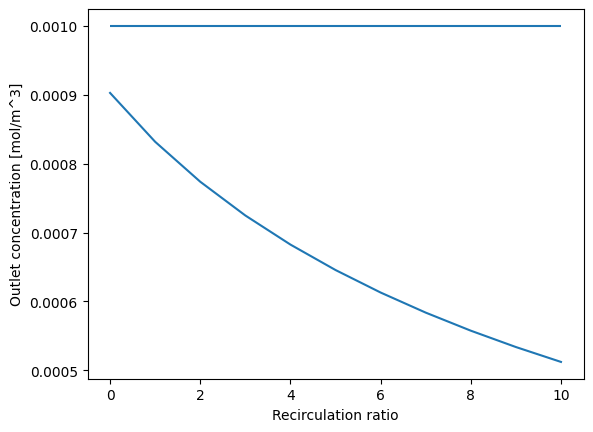

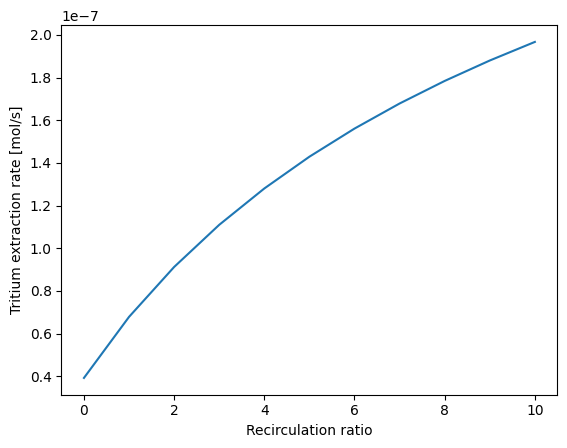

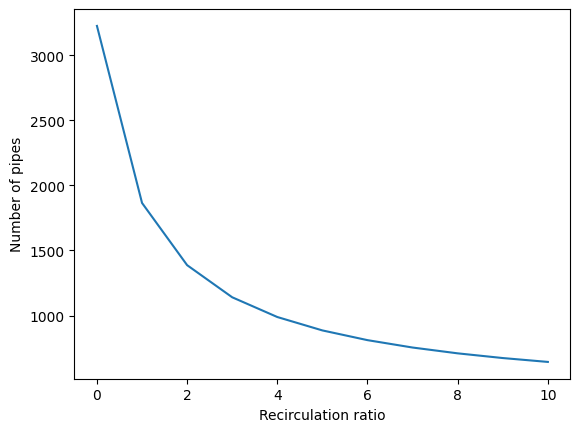

In [13]:
plt.plot(recirculation_vec,c_out_PAV_vec)
plt.hlines(c0,recirculation_vec[0],recirculation_vec[-1])
plt.xlabel("Recirculation ratio")
plt.ylabel("Outlet concentration [mol/m^3]")
plt.show()
plt.plot(recirculation_vec,extract_vec)
plt.xlabel("Recirculation ratio")
plt.ylabel("Tritium extraction rate [mol/s]")
plt.show()
plt.plot(recirculation_vec,n_pipes_vec)
plt.xlabel("Recirculation ratio")
plt.ylabel("Number of pipes")
plt.show()

We can do the same analysis, but with the inclusion of a Breeding blanket object. By connecting the inlet concentration of the breeding blanket and the outlet of the PAV, we can use the same While looping techniques to close the circuit and see a concentration uptake in the BB, which is also reflected by the PAV. To do this analysis, we must decide a priori how many pipes we want to use for Tritium extraction.  

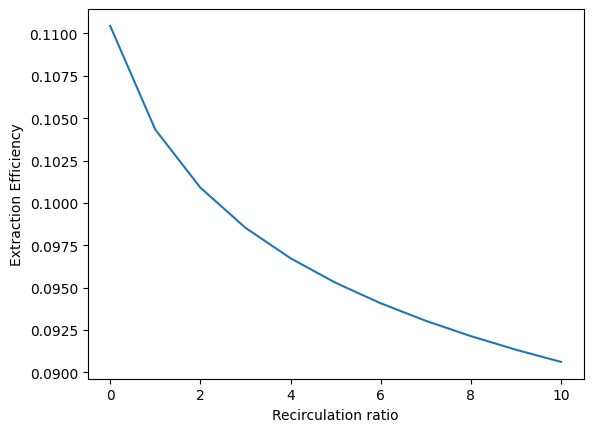

In [14]:
%reset -f
from scipy.constants import N_A
from scipy.constants import physical_constants
import numpy as np 
from TRIOMA.tools.Extractors.PAV import Component,Membrane ,Geometry ,Fluid
import TRIOMA.tools.materials as materials
import matplotlib.pyplot as plt
from scipy.constants import R
from TRIOMA.tools.BreedingBlanket import BreedingBlanket
recirculation_vec=np.linspace(0,10,11)
c_out_PAV_vec=np.array([])
eff_vec=np.array([])
extract_vec=np.array([])
n_pipes_vec=np.array([])
c_out_BB_vec=np.array([])
for recirculation in recirculation_vec:
    T=973.15
    L=10
    d_hyd=25.4E-3
    
    mat=materials.Flibe(T)
    rho_flibe=2415.6-0.49072*T
    n_pipes=5000
    
    mu_flibe=1.16E-4*np.exp(3755/T)
    k_H=8.27E-9*np.exp(4.27E-3*T)
    D_flibe=9.3E-7*np.exp((-42E3)/(R*T))
    K_S_S=953*np.exp((-10.7E3)/(R*T))*1E-3
    D_S=7.43E-7*np.exp((-44.1E3)/(R*T))
    flibe=Fluid(T=T, Solubility=k_H, MS=True,D=D_flibe, d_Hyd=d_hyd ,mu=mu_flibe,rho=rho_flibe,U0=1,k=mat.k,
        cp=mat.cp)
    BB=BreedingBlanket(Q=0.625E9,TBR=1.08,T_in=800,T_out=900,c_in=0, fluid=flibe)
    BB.get_flowrate()
    BB.get_cout()
    c0=BB.c_out
    U0=BB.m_coolant/(rho_flibe*np.pi*d_hyd**2/4*n_pipes)
    err=1
    tol=1E-6
    c_in=c0
    i=0
    flibe=Fluid(T=T, Solubility=k_H, MS=True,D=D_flibe, d_Hyd=d_hyd ,mu=mu_flibe,rho=rho_flibe,U0=U0*(recirculation+1),k=mat.k,
        cp=mat.cp)
    Steel = Membrane( T=T,
            D=D_S,
            thick=0.25E-3,
            K_S=K_S_S,
            k_d=1E6,
            k_r=1E6,k=21)
    PAV_geometry=Geometry(D=d_hyd,L=L,thick=0.25E-3)
     
    while err>tol:
        i=i+1
        
        err2=1
        tol2=1E-6
        j=0
        while err2>tol2:
            j=j+1
            c_in1=c_in
            PAV = Component(c_in=c_in,geometry=PAV_geometry, fluid=flibe, membrane=Steel)   
            PAV.analytical_efficiency()
            PAV.update_attribute("eff",PAV.eff_an)
            PAV.outlet_c_comp()
            c_in=(PAV.c_out*recirculation+BB.c_out)/(recirculation+1)
            err2=abs((c_in-c_in1)/c_in)
        err=abs((PAV.c_out-BB.c_in)/PAV.c_out)
        BB.update_attribute("c_in",PAV.c_out)
        BB.get_cout()
    c_out_PAV_vec=np.append(c_out_PAV_vec,PAV.c_out)
    c_out_BB_vec=np.append(c_out_BB_vec,BB.c_out)
    eff_vec=np.append(eff_vec,PAV.eff_an)
    extract_vec=np.append(extract_vec,(PAV.c_in-PAV.c_out)*PAV.fluid.U0*PAV.fluid.d_Hyd**2/4)
plt.plot(recirculation_vec,eff_vec)
plt.xlabel("Recirculation ratio")
plt.ylabel("Extraction Efficiency")
plt.show()

In this plot we can see the uptake of Tritium in the system. The outlet concentration in the PAV is higher than the outlet concentration of the breeding blanket in the case in which this is furnished by T-free fluid (horizontal line). We can also observe that the amount of extracted tritium is always equal to the produced tritium for each recirculation ratio, which is an expected result

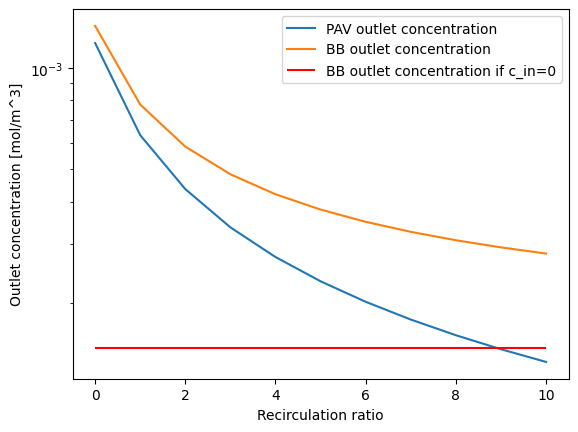

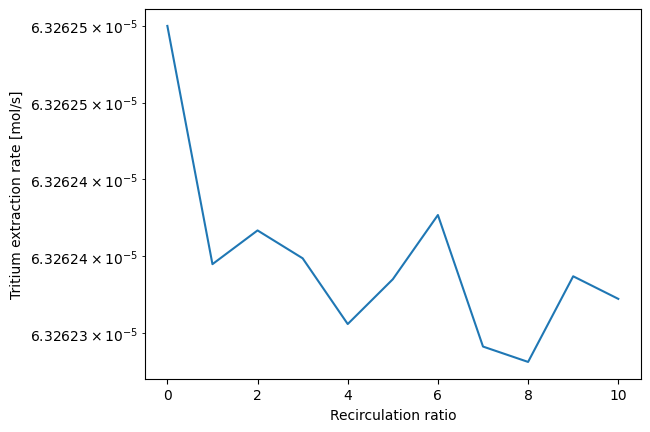

In [15]:
plt.semilogy(recirculation_vec,c_out_PAV_vec, label="PAV outlet concentration")
plt.semilogy(recirculation_vec,c_out_BB_vec,label="BB outlet concentration")
plt.hlines(c0,recirculation_vec[0],recirculation_vec[-1],'r',label="BB outlet concentration if c_in=0")
plt.legend(loc="upper right")
plt.xlabel("Recirculation ratio")
plt.ylabel("Outlet concentration [mol/m^3]")
plt.show()
plt.semilogy(recirculation_vec,extract_vec*n_pipes)
plt.xlabel("Recirculation ratio")
plt.ylabel("Tritium extraction rate [mol/s]")
plt.show()

In the next snippet, we add a new component, the heat exchanger, following the PAV. We define a new fluid, FLibe at a different temperature (average HX temperature), and different diameter, velocity and number of pipes than the PAV. Then we evaluate the universal heat transfer efficient, we suppose no resistance from the secondary, and evaluate the length of the HX. We get the extraction efficiency of this component (extraction here means losses) and we connect HX.c_out to BB.c_in

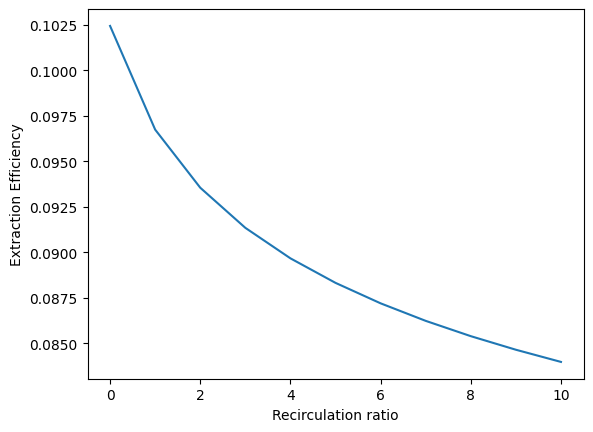

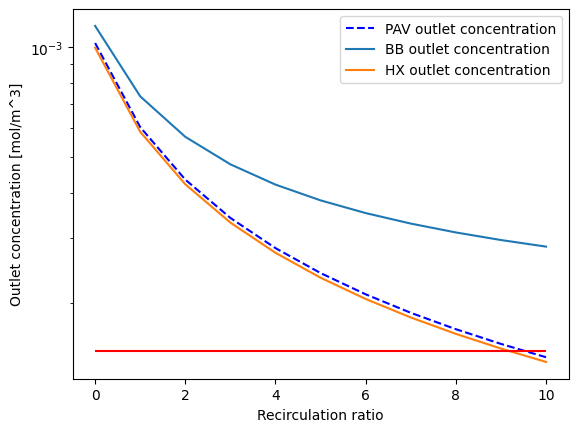

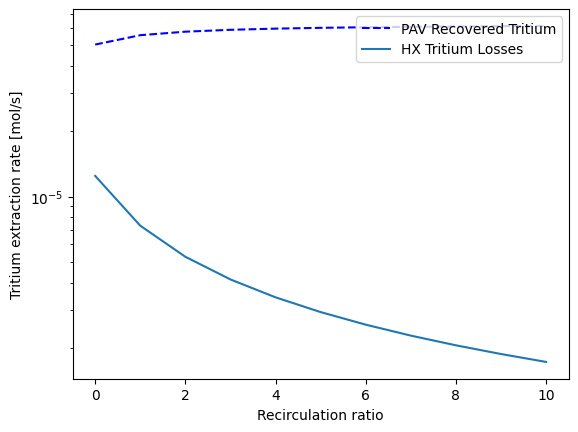

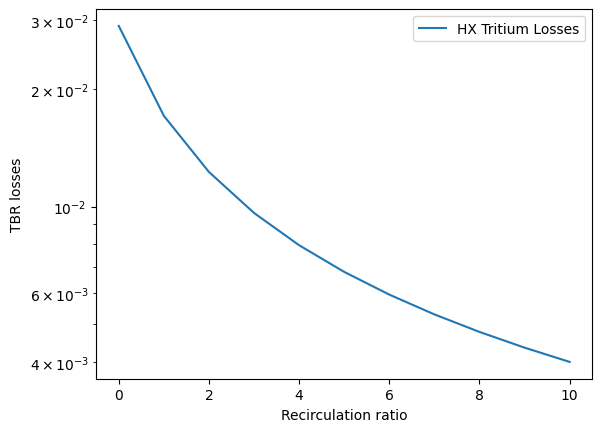

In [16]:
%reset -f
from scipy.constants import N_A
from scipy.constants import physical_constants
import numpy as np 
from TRIOMA.tools.Extractors.PAV import Component,Membrane ,Geometry ,Fluid
import TRIOMA.tools.materials as materials
import matplotlib.pyplot as plt
from scipy.constants import R
from TRIOMA.tools.BreedingBlanket import BreedingBlanket
import TRIOMA.tools.correlations  as corr  
recirculation_vec=np.linspace(0,10,11)
c_out_PAV_vec=np.array([])
eff_vec=np.array([])
extract_vec=np.array([])
n_pipes_vec=np.array([])
c_out_BB_vec=np.array([])
c_out_HX_vec=np.array([])
losses_vec=np.array([])
for recirculation in recirculation_vec:
    T=973.15
    L=10
    d_hyd=25.4E-3
    
    mat=materials.Flibe(T)
    
    rho_flibe=2415.6-0.49072*T
    n_pipes=2000
    n_pipes_HX=3000
    mu_flibe=1.16E-4*np.exp(3755/T)
    k_H=8.27E-9*np.exp(4.27E-3*T)
    D_flibe=9.3E-7*np.exp((-42E3)/(R*T))
    K_S_S=953*np.exp((-10.7E3)/(R*T))*1E-3
    D_S=7.43E-7*np.exp((-44.1E3)/(R*T))
    
    flibe=Fluid(T=T, Solubility=k_H, MS=True,D=D_flibe, d_Hyd=d_hyd ,mu=mu_flibe,rho=rho_flibe,U0=1,k=mat.k,
        cp=mat.cp)
    BB=BreedingBlanket(Q=0.625E9,TBR=1.08,T_in=800,T_out=900,c_in=0, fluid=flibe)
    BB.get_flowrate()
    BB.get_cout()
    c0=BB.c_out
    U0=BB.m_coolant/(rho_flibe*np.pi*d_hyd**2/4*n_pipes)
    err=1
    tol=1E-6
    c_in=c0
    i=0
    geometry=Geometry(D=d_hyd,L=L,thick=0.25E-3)
    flibe=Fluid(T=T, Solubility=k_H, MS=True,D=D_flibe, d_Hyd=d_hyd ,mu=mu_flibe,rho=rho_flibe,U0=U0*(recirculation+1),k=mat.k,
        cp=mat.cp)
    Steel = Membrane( T=T,
            D=D_S,
            thick=0.25E-3,
            K_S=K_S_S,
            k_d=1E6,
            k_r=1E6,k=21)
    mat_HX=materials.Flibe((BB.T_in+BB.T_out)/2)
    d_hyd_HX=50E-3
    U0_HX=BB.m_coolant/(mat_HX.rho*np.pi*d_hyd_HX**2/4*n_pipes_HX)
    flibe_HX=Fluid(T=(BB.T_in+BB.T_out)/2, Solubility=mat_HX.Solubility, MS=True,D=mat_HX.D, d_Hyd=d_hyd_HX ,mu=mat_HX.mu,U0=U0_HX,rho=mat_HX.rho,k=mat.k,cp=mat_HX.cp)
    geometry_HX=Geometry(D=d_hyd_HX,L=L,thick=0.25E-3)
    HX = Component(c_in=c_in,geometry=geometry_HX, fluid=flibe_HX, membrane=Steel)
    PAV_geometry=Geometry(D=d_hyd,L=L,thick=0.25E-3)
    while err>tol:
        i=i+1
        
        err2=1
        tol2=1E-6
        j=0
        while err2>tol2:
            j=j+1
            c_in1=c_in
            PAV = Component(c_in=c_in,geometry=PAV_geometry, fluid=flibe, membrane=Steel)    
            PAV.analytical_efficiency()
            PAV.update_attribute("eff",PAV.eff_an)
            PAV.outlet_c_comp()
            c_in=(PAV.c_out*recirculation+BB.c_out)/(recirculation+1)
            err2=abs((c_in-c_in1)/c_in)
        HX.update_attribute("c_in",PAV.c_out)
        HX.get_global_HX_coeff(0)
        L_HX=corr.get_length_HX(deltaTML=(corr.get_deltaTML(BB.T_out, BB.T_in,581, 800)), d_hyd=HX.fluid.d_Hyd, U=HX.U, Q=BB.Q/n_pipes_HX)
        HX.update_attribute("L",L_HX)
        HX.use_analytical_efficiency()
        HX.outlet_c_comp()
        
        err=abs((HX.c_out-BB.c_in)/HX.c_out)
        BB.update_attribute("c_in",HX.c_out)
        BB.get_cout()
    c_out_PAV_vec=np.append(c_out_PAV_vec,PAV.c_out)
    c_out_BB_vec=np.append(c_out_BB_vec,BB.c_out)
    c_out_HX_vec=np.append(c_out_HX_vec,HX.c_out)
    eff_vec=np.append(eff_vec,PAV.eff_an)
    extract_vec=np.append(extract_vec,(PAV.c_in-PAV.c_out)*PAV.fluid.U0*PAV.fluid.d_Hyd**2/4)
    losses_vec=np.append(losses_vec,(HX.c_in-HX.c_out)*HX.fluid.U0*HX.fluid.d_Hyd**2/4)
plt.plot(recirculation_vec,eff_vec)
plt.xlabel("Recirculation ratio")
plt.ylabel("Extraction Efficiency")
plt.show()
plt.semilogy(recirculation_vec,c_out_PAV_vec,'--b',label="PAV outlet concentration")
plt.semilogy(recirculation_vec,c_out_BB_vec,label="BB outlet concentration")
plt.semilogy(recirculation_vec,c_out_HX_vec,label="HX outlet concentration")
plt.hlines(c0,recirculation_vec[0],recirculation_vec[-1],'r')
plt.xlabel("Recirculation ratio")
plt.ylabel("Outlet concentration [mol/m^3]")
plt.legend( loc='upper right')
plt.show()
plt.semilogy(recirculation_vec,extract_vec*n_pipes,'--b',label="PAV Recovered Tritium")
plt.semilogy(recirculation_vec,losses_vec*n_pipes_HX,label="HX Tritium Losses")
plt.xlabel("Recirculation ratio")
plt.ylabel("Tritium extraction rate [mol/s]")
plt.legend( loc='upper right')
plt.show()

Q=0.625E9
TBR=1.08
eV_to_J = physical_constants["electron volt-joule relationship"][0]
reaction_energy = 17.6e6  # reaction energy in eV 17.6 MeV
neutrons = Q / (reaction_energy * eV_to_J)

tritium_gen = TBR * neutrons / N_A 
#plt.semilogy(recirculation_vec,extract_vec*n_pipes,'--b',label="PAV Recovered Tritium")
plt.semilogy(recirculation_vec,(losses_vec*n_pipes_HX)/tritium_gen/TBR,label="HX Tritium Losses")
plt.xlabel("Recirculation ratio")
plt.ylabel("TBR losses")
plt.legend( loc='upper right')
plt.show()

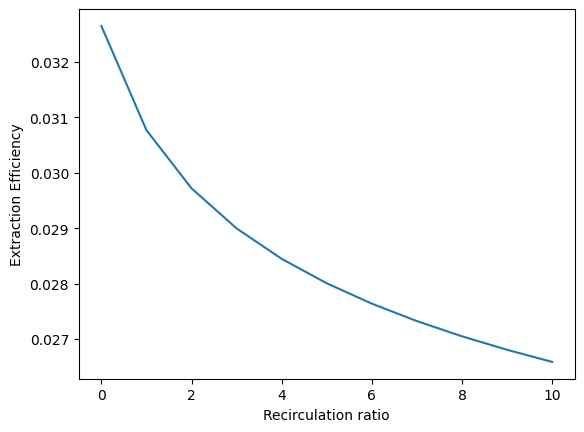

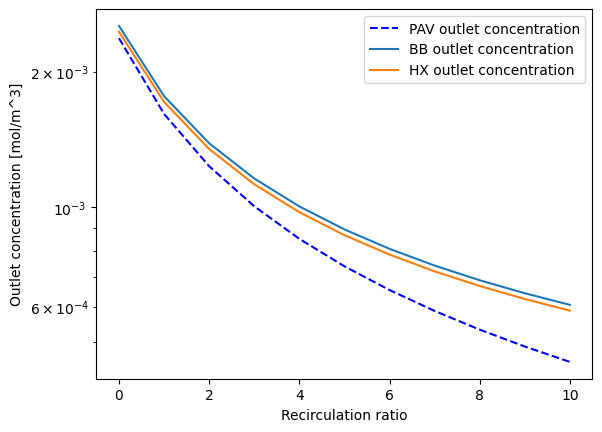

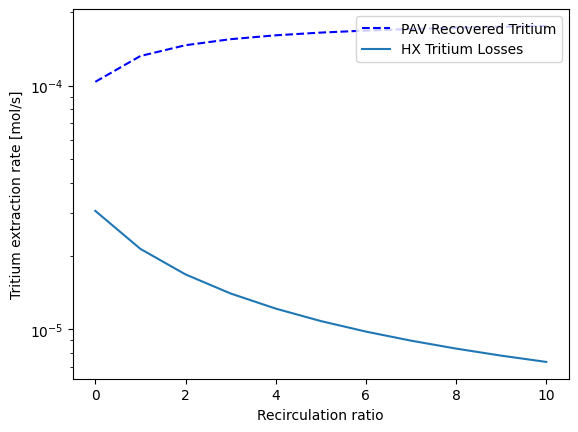

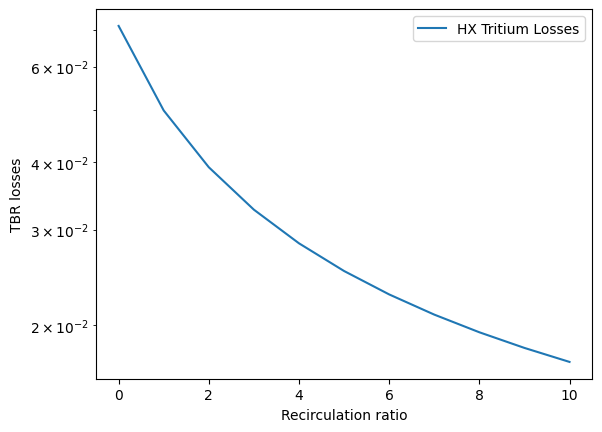

c_in: 0.0004646715511362134
geometry: <TRIOMA.tools.Extractors.PipeSubclasses.Geometry object at 0x0000022B4F5EEE50>
eff: 0.026585689985901717
n_pipes: (1,)
fluid: <TRIOMA.tools.Extractors.PipeSubclasses.Fluid object at 0x0000022B4B93EF50>
membrane: <TRIOMA.tools.Extractors.PipeSubclasses.Membrane object at 0x0000022B2C2D8150>
name: None
loss: False
inv: None
p_out: 1e-15
delta_p: None
U: None
pumping_power: None
cost: None
update_attribute: <bound method Component.custom_update_attribute of <TRIOMA.tools.Extractors.PAV.Component object at 0x0000022B4F60B250>>
tau: 0.026946740385858772
alpha: 2.4512863675628416
xi: 5275.309757115459
eff_an: 0.026585689985901717
c_out: 0.00045231793733243794
pipe_flowrate: 0.007121495963779306
c_in: 0.0006058114800844214
geometry: <TRIOMA.tools.Extractors.PipeSubclasses.Geometry object at 0x0000022B4F5EFD10>
eff: 0.029049990411761595
n_pipes: (1,)
fluid: <TRIOMA.tools.Extractors.PipeSubclasses.Fluid object at 0x0000022B3B74A4D0>
membrane: <TRIOMA.tools.

In [17]:
%reset -f
from scipy.constants import N_A
from scipy.constants import physical_constants
import numpy as np 
from TRIOMA.tools.Extractors.PAV import Component,Membrane ,Geometry ,Fluid
import TRIOMA.tools.materials as materials
import matplotlib.pyplot as plt
from scipy.constants import R
from TRIOMA.tools.BreedingBlanket import BreedingBlanket
import TRIOMA.tools.correlations  as corr 
recirculation_vec=np.linspace(0,10,11)
c_out_PAV_vec=np.array([])
eff_vec=np.array([])
extract_vec=np.array([])
n_pipes_vec=np.array([])
c_out_BB_vec=np.array([])
c_out_HX_vec=np.array([])
losses_vec=np.array([])
for recirculation in recirculation_vec:
    T=800
    L=10
    d_hyd=25.4E-3
    
    mat=materials.Flibe(T)
    
    rho_flibe=2415.6-0.49072*T
    n_pipes=2000
    n_pipes_HX=3000
    mu_flibe=1.16E-4*np.exp(3755/T)
    k_H=8.27E-9*np.exp(4.27E-3*T)
    D_flibe=9.3E-7*np.exp((-42E3)/(R*T))
    K_S_S=953*np.exp((-10.7E3)/(R*T))*1E-3
    D_S=7.43E-7*np.exp((-44.1E3)/(R*T))
    flibe=Fluid(T=T, Solubility=k_H, MS=True,D=D_flibe, d_Hyd=d_hyd ,mu=mu_flibe,rho=rho_flibe,U0=1,k=mat.k,
        cp=mat.cp)
    BB=BreedingBlanket(Q=0.625E9,TBR=1.08,T_in=800,T_out=900,c_in=0, fluid=flibe)
    BB.get_flowrate()
    BB.get_cout()
    c0=BB.c_out
    U0=BB.m_coolant/(rho_flibe*np.pi*d_hyd**2/4*n_pipes)
    err=1
    tol=1E-6
    c_in=c0
    i=0
    flibe=Fluid(T=800, Solubility=k_H, MS=True,D=D_flibe, d_Hyd=d_hyd ,mu=mu_flibe,rho=rho_flibe,U0=U0*(recirculation+1),k=mat.k,
        cp=mat.cp)
    Steel = Membrane( T=T,
            D=D_S,
            thick=0.25E-3,
            K_S=K_S_S,
            k_d=1E6,
            k_r=1E6,k=21)
    mat_HX=materials.Flibe((BB.T_in+BB.T_out)/2)
    d_hyd_HX=50E-3
    U0_HX=BB.m_coolant/(mat_HX.rho*np.pi*d_hyd_HX**2/4*n_pipes_HX)
    flibe_HX=Fluid(T=(BB.T_in+BB.T_out)/2, Solubility=mat_HX.Solubility, MS=True,D=mat_HX.D, d_Hyd=d_hyd_HX ,mu=mat_HX.mu,U0=U0_HX,rho=mat_HX.rho,k=mat.k,cp=mat_HX.cp)
    geometry_HX=Geometry(D=d_hyd_HX,L=L,thick=0.25E-3)
    PAV_geometry=Geometry(D=d_hyd,L=L,thick=0.25E-3)
    HX = Component(c_in=c_in,geometry=geometry_HX, fluid=flibe_HX, membrane=Steel)
    while err>tol:
        i=i+1
        
        err2=1
        tol2=1E-6
        j=0
        
        HX = Component(c_in=BB.c_out,geometry=geometry_HX, fluid=flibe_HX, membrane=Steel)
        HX.get_global_HX_coeff(0)
        L_HX=corr.get_length_HX(deltaTML=(corr.get_deltaTML(BB.T_out, BB.T_in,581, 800)), d_hyd=HX.fluid.d_Hyd, U=HX.U, Q=BB.Q/n_pipes_HX)
        HX.update_attribute("L",L_HX)
        HX.use_analytical_efficiency()
        HX.outlet_c_comp()
        while err2>tol2:
            j=j+1
            c_in1=c_in
            PAV = Component(c_in=c_in,geometry=PAV_geometry, fluid=flibe, membrane=Steel)  
            PAV.analytical_efficiency()
            PAV.update_attribute("eff",PAV.eff_an)
            PAV.outlet_c_comp()
            c_in=(PAV.c_out*recirculation+HX.c_out)/(recirculation+1)
            err2=abs((c_in-c_in1)/c_in)
        err=abs((PAV.c_out-BB.c_in)/PAV.c_out)
        BB.update_attribute("c_in",PAV.c_out)
        BB.get_cout()
    c_out_PAV_vec=np.append(c_out_PAV_vec,PAV.c_out)
    c_out_BB_vec=np.append(c_out_BB_vec,BB.c_out)
    c_out_HX_vec=np.append(c_out_HX_vec,HX.c_out)
    eff_vec=np.append(eff_vec,PAV.eff_an)
    extract_vec=np.append(extract_vec,PAV.T_leak())
    losses_vec=np.append(losses_vec,(HX.c_in-HX.c_out)*HX.fluid.U0*HX.fluid.d_Hyd**2/4)
plt.plot(recirculation_vec,eff_vec)
plt.xlabel("Recirculation ratio")
plt.ylabel("Extraction Efficiency")
plt.show()
plt.semilogy(recirculation_vec,c_out_PAV_vec,'--b',label="PAV outlet concentration")
plt.semilogy(recirculation_vec,c_out_BB_vec,label="BB outlet concentration")
plt.semilogy(recirculation_vec,c_out_HX_vec,label="HX outlet concentration")
plt.hlines(c0,recirculation_vec[0],recirculation_vec[-1],'r')
plt.xlabel("Recirculation ratio")
plt.ylabel("Outlet concentration [mol/m^3]")
plt.legend( loc='upper right')
plt.show()
plt.semilogy(recirculation_vec,extract_vec*n_pipes,'--b',label="PAV Recovered Tritium")
plt.semilogy(recirculation_vec,losses_vec*n_pipes_HX,label="HX Tritium Losses")
plt.xlabel("Recirculation ratio")
plt.ylabel("Tritium extraction rate [mol/s]")
plt.legend( loc='upper right')
plt.show()

Q=0.625E9
TBR=1.08
eV_to_J = physical_constants["electron volt-joule relationship"][0]
reaction_energy = 17.6e6  # reaction energy in eV 17.6 MeV
neutrons = Q / (reaction_energy * eV_to_J)

tritium_gen = TBR * neutrons / N_A 
#plt.semilogy(recirculation_vec,extract_vec*n_pipes,'--b',label="PAV Recovered Tritium")
plt.semilogy(recirculation_vec,(losses_vec*n_pipes_HX)/tritium_gen/TBR,label="HX Tritium Losses")
plt.xlabel("Recirculation ratio")
plt.ylabel("TBR losses")
plt.legend( loc='upper right')
plt.show()
PAV.inspect()
HX.inspect()